### Mushroom classification
#### Notebook's autor: Piotr Grabysz
#### Date: 11.03.2021

#### Short description of the project

This notebook is about mushroom classification. The dataset can be found here: https://www.kaggle.com/uciml/mushroom-classification?select=mushrooms.csv

According to Kaggle's description, The Audubon Society Field Guide to North American Mushrooms (1981) states that there is no simple rule for determining the edibility of a mushroom.

So the goal here is to learn which features spell certain death and which corresponds to edibility in this dataset of mushroom characteristics. It is also important to understand how certain the model can be.

Let's investigate the data:

In [1]:
import pandas as pd
mushrooms = pd.read_csv("./mushrooms.csv")

mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


There are 23 categorical variables. The *class* variable means edible for *e* and poisonous for *p*. 

Let's see if the number of edible samples is equal to the number of poisonous samples:

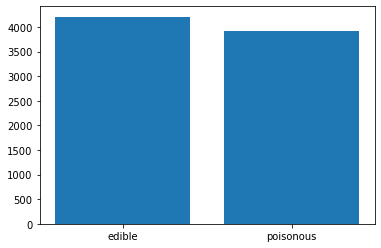

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(["edible", "poisonous"], [mushrooms["class"].value_counts()["e"], mushrooms["class"].value_counts()["p"]])
plt.show()

Yes, the ratio of poisonous vs edible mushrooms is more or less equal.

One of the goals is to find feautures that might be important, so I use random forest, because it allows to easily see which features contribute most to the model's accuracy. But because the variables are categorical, I firstly do one hot encoding on them.

In [3]:
from sklearn import preprocessing

X = mushrooms.drop("class", axis=1)
y = mushrooms["class"]

# one-hot-encode dependent variables
enc = preprocessing.OneHotEncoder(drop='first')
X = enc.fit_transform(X)

# binarize the class variable
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y).ravel()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from numpy import mean

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
acc = mean(preds == y_test)
print(f"The accuracy of the model is {acc*100:.3f}%")

The accuracy of the model is 100.000%


The model has reached 100% accuracy without any hyperparameters tuning! It is totally unexpected to me, especially that the Kaggle's description mentioned the book about mushrooms, in which there is a statement that *there is no simple rule for determining the edibility of a mushroom*!

It is so surprising that I spent some time looking for an error but it turns out that this model is really so good. So it is very likely that there is a simple rule to determine edibility. Let's investigate the feature importance:

In [5]:
importances = list(rf_model.feature_importances_)

# names of one-hot-encoded features
feature_list = enc.get_feature_names( mushrooms.drop("class", axis=1).columns)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort feature_importances in decreasing order
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the features and their importances 
[print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: odor_n                    Importance: 0.13
Variable: odor_f                    Importance: 0.09
Variable: gill-size_n               Importance: 0.09
Variable: ring-type_p               Importance: 0.06
Variable: bruises_t                 Importance: 0.04
Variable: stalk-surface-above-ring_k Importance: 0.04
Variable: stalk-surface-below-ring_k Importance: 0.04
Variable: spore-print-color_h       Importance: 0.04
Variable: gill-spacing_w            Importance: 0.03
Variable: stalk-surface-above-ring_s Importance: 0.03
Variable: spore-print-color_w       Importance: 0.03
Variable: population_v              Importance: 0.03
Variable: odor_p                    Importance: 0.02
Variable: stalk-shape_t             Importance: 0.02
Variable: stalk-root_e              Importance: 0.02
Variable: ring-type_l               Importance: 0.02
Variable: cap-surface_s             Importance: 0.01
Variable: cap-color_w               Importance: 0.01
Variable: cap-color_y               Importa

The above features are the one-hot-encoded features. The most important features are *odor_f* and *odor_n* which corresponds to foul (it is synonym to disgusting) odor and none odor. Let's see the distribution of classes vs odor labels:

In [6]:
mushrooms.groupby(['odor'])['class'].value_counts().to_frame()

class
odor class       
a    e        400
c    p        192
f    p       2160
l    e        400
m    p         36
n    e       3408
     p        120
p    p        256
s    p        576
y    p        576

One can witness here the very extreme purity. Every odor correlates *excactly* to edibility except if there is no odor, since there is a small chance that the mushroom is poisonous then. This chance is 120/8124 = 0.0148, so the classifier based solely on the odor variable could reach near 100% accuracy.

So, if you are interested in mushroom hunting, quite a simple and intuitive rule can be extracted while looking at the above table. If the mushroom has any smell, it is more likely that it is poisonous. It is surely poisonous if this smell is creosote,fishy, foul, musty, pungent or spicy and surely edible if the smell is almond or anise. If there is no smell then you can be 96.48% sure that the mushroom is edible.

In case of the above model, there is a chance that it reached the 100% accuracy because there are no samples in the test set with class="p" and odor="n" (meaning there are no difficult samples in the test_set). It is important to check if the split into train and test sets is balanced.

In [7]:
# get the index of odor_n column in the one-hot-encoded matrix
for i, name in enumerate(feature_list):
    if "odor_n" in name:
        print(f"Found odor_n at index {i}")

Found odor_n at index 22


In [8]:
import scipy
print("Number of rows with odor==n and class==p in the training set:", \
      y_train[scipy.sparse.find(X_train[:,22]==1)[0]].sum()
     )

print("Number of rows with odor==n and class==p in the test set:", \
y_test[scipy.sparse.find(X_test[:,22]==1)[0]].sum()
     )

Number of rows with odor==n and class==p in the training set: 100
Number of rows with odor==n and class==p in the test set: 20


Therefore there are 20 samples which belongs to the only difficult class in the data set (no odor and poisonous) and yet the model classifies them correctly.

Finally, let's see take a look at aggregated features importance, where one-hot-encoded features are summed up if they belong to the same category.

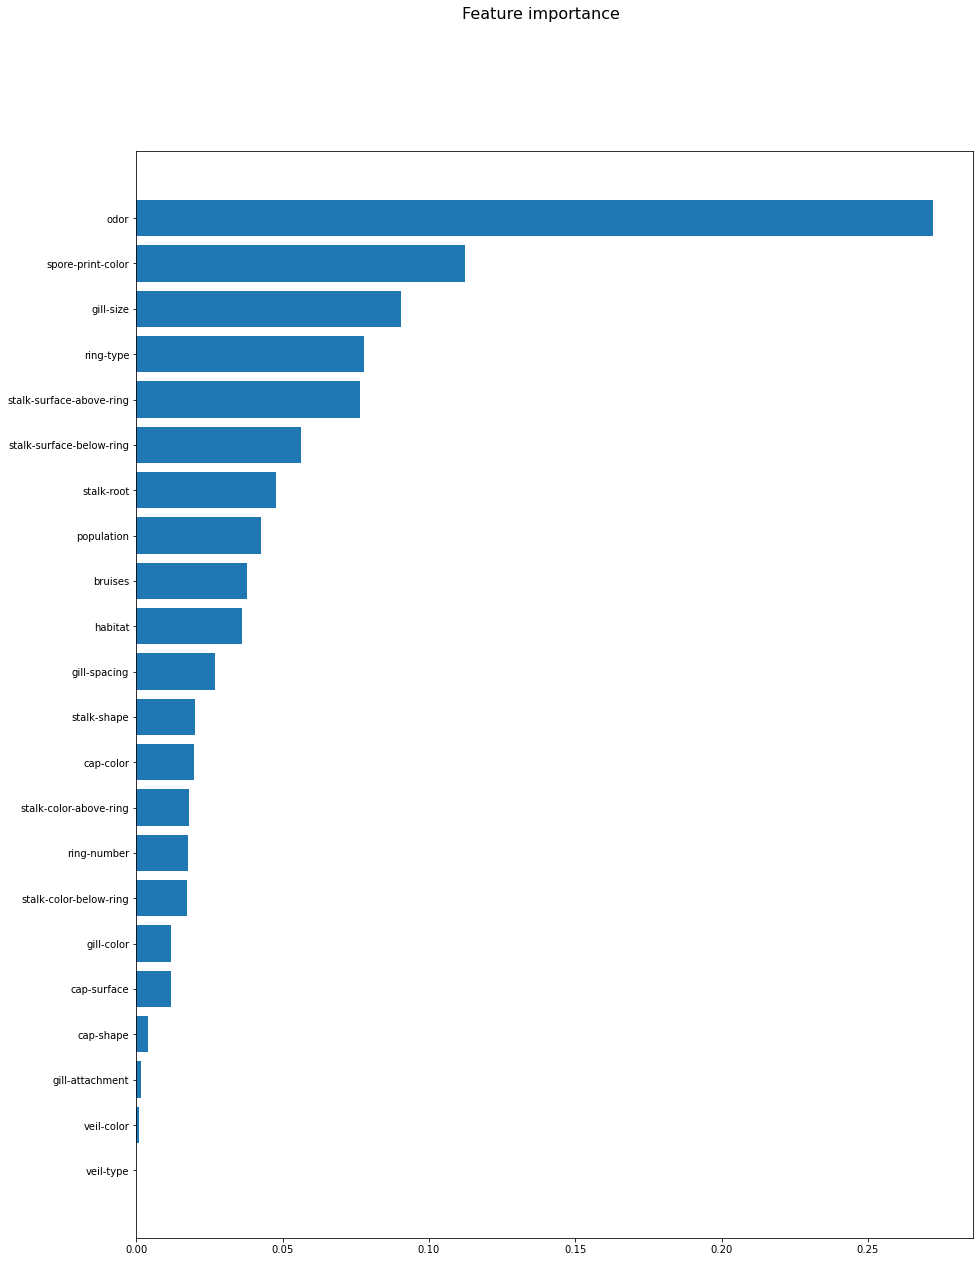

In [9]:
col_names = mushrooms.drop("class", axis=1).columns

feature_importances = dict()
# the column name (feature name) is the key, and its importance is the value
# initialize the dictionary with zeros:
for col_name in col_names:
    feature_importances[col_name] = 0.

# sum up the importances
for feature, importance in zip(feature_list, importances):
    for col_name in col_names:
        if col_name in feature:
            feature_importances[col_name] += importance

# sort importances in descending order
feature_importances = sorted(feature_importances.items(), key = lambda x: x[1], reverse = False)

plt.figure(figsize=(15,20))
plt.barh([pair[0] for pair in feature_importances], [pair[1] for pair in feature_importances])
plt.suptitle("Feature importance", fontsize=16)
plt.show()